In [26]:
"""
activeness.ipynb 分析全市场股票的股性, 从而获得A股中的核心活跃股

需要首先运行 src/analysis/up_limit_times.py 计算过去一年全市场股票的涨停次数

    @Time    : 2025/04/24
    @Author  : JackWang
    @File    : activeness.py
    @IDE     : VsCode
    @Copyright Copyright Shihong Wang (c) 2025 with GNU Public License V3.0
"""

# Standard Library
from pathlib import Path
from datetime import datetime, timedelta

# Third-Party Library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# My Library
from notebook_utils import find_my_library

with find_my_library() as project_root:
    cache_dir = project_root / "cache"
    
    from src.utils.config import load_config
    from src.utils.draw import setup_matplotlib
    from src.core.tushare_proxy import TuShareProxy
    from src.utils.tools import tscode2symbol, get_relative_trade_day
    
    setup_matplotlib()

config = load_config()
proxy = TuShareProxy(config)

# 读取数据

In [27]:
csv_path = Path(project_root) / "analysis/up_limit_times.csv"
if not csv_path.exists():
    raise FileNotFoundError(f"File {csv_path} does not exist.")

# 读取数据
df = pd.read_csv(csv_path)
df.head(5)

,ts_code,name,up_limit_times,max_continue_up_times
0,002717.SZ,岭南股份,41,6
1,002693.SZ,双成药业,41,14
2,600889.SH,南京化纤,32,12
3,002713.SZ,东易日盛,32,4
4,002640.SZ,跨境通,31,7


# 涨停次数图

呈现明显的长尾分布

<Axes: xlabel='index', ylabel='up_limit_times'>

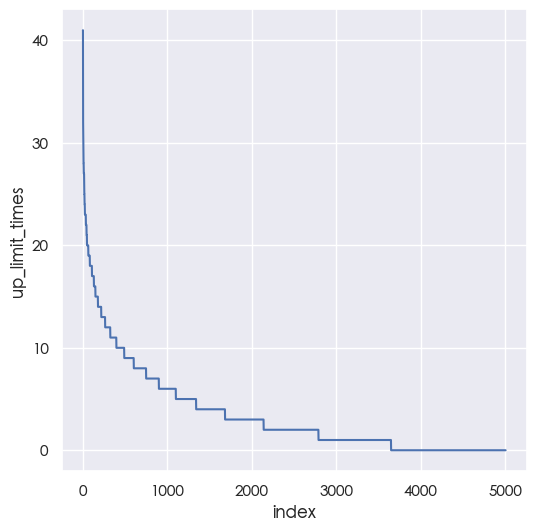

In [28]:
f, ax = plt.subplots(figsize=(6, 6))
sns.lineplot(x="index", y="up_limit_times", data=df.reset_index())

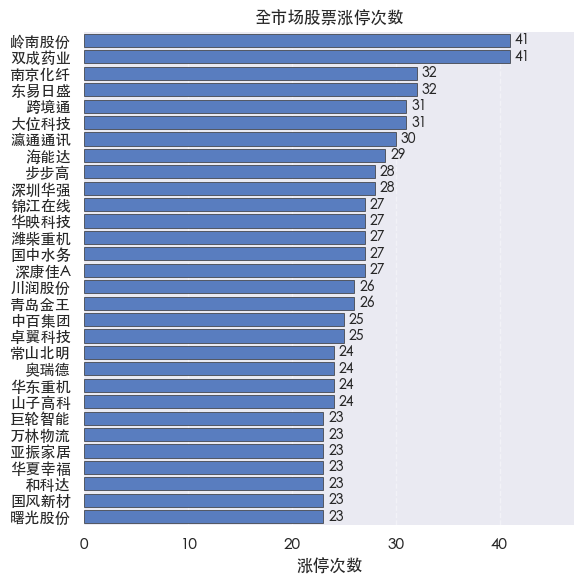

In [29]:
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes("muted")  # 使用柔和色调

barplot = sns.barplot(
    x="up_limit_times", 
    y="name", 
    data=df[:30],
    color="b",          # 蓝色系
    orient="h",         # 横向显示
    edgecolor=".2",     # 边框色
    linewidth=.5        # 边框粗细
)

for p in barplot.patches:
    width = p.get_width()
    ax.text(
        width + 0.5,               # X坐标：柱长+0.5单位
        p.get_y() + p.get_height()/2,  # Y坐标：柱体中央
        f'{int(width)}',           # 显示整数值
        ha='left',                 # 水平左对齐
        va='center',               # 垂直居中
        fontsize=10
    )

ax.set(xlabel="股票名称", ylabel="涨停次数", title="全市场股票涨停次数")
ax.set(
    xlabel="涨停次数",
    ylabel="",
    xlim=(0, df['up_limit_times'].max() * 1.15)  # 留15%空白
)
ax.xaxis.grid(True, linestyle='--', alpha=0.4)   # 只显示横向网格线
sns.despine(left=True, bottom=True)  # 移除左侧和底部边框

plt.tight_layout()  # 自动调整布局

# 28规律验证

截止2025.4.25日收盘, 过去一年涨停次数前27%的股票的涨停次数占了市场全部涨停次数的72%, 符合28规律

阈值在5, 即过去一年中涨停次数大于5次是一个分水岭.
 - 有 1340 只股票过去一年涨停次数超过5次, 贡献了 12639 次涨停, 占比 71.98%
 - 有 3664 只股票过去一年涨停次数小于5次, 贡献了 4920 次涨停, 占比 28.02%

所以, 过去一年涨停次数超过五次就可以算作A股中的核心股

(np.float64(0.724482837008411), np.float64(0.2757444873834963))

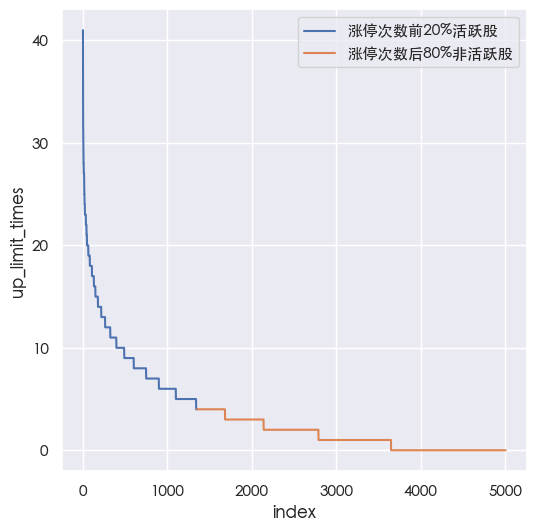

In [33]:
num_shares = len(df)
num_active_shares = int(0.27 * num_shares)

f, ax = plt.subplots(figsize=(6, 6))
sns.lineplot(x="index", y="up_limit_times", data=df.reset_index()[:num_active_shares], label="涨停次数前20%活跃股")
sns.lineplot(x="index", y="up_limit_times", data=df.reset_index()[num_active_shares:], label="涨停次数后80%非活跃股")

total_up_times = df.loc[:, "up_limit_times"].sum()
active_up_times = df.loc[:num_active_shares, "up_limit_times"].sum()
non_active_up_times = df.loc[num_active_shares:, "up_limit_times"].sum()
active_up_times/ total_up_times, non_active_up_times / total_up_times

In [34]:
freq_table = df["up_limit_times"].value_counts().sort_index().reset_index()

mask = freq_table["up_limit_times"] >= 5
a = (freq_table[mask]["count"] * freq_table[mask]["up_limit_times"]).sum()
b = (freq_table[~mask]["count"] * freq_table[~mask]["up_limit_times"]).sum()
a, b, a / (a + b), b / (a + b), freq_table[mask]["count"].sum(), freq_table[~mask]["count"].sum()

(np.int64(12700),
 np.int64(4896),
 np.float64(0.721754944305524),
 np.float64(0.278245055694476),
 np.int64(1340),
 np.int64(3664))

# 涨停次数分布表
针对核心股, 对其进行等宽分组, 一共分为三组, 分别是:
- 涨停次数5~13: 1123只股票
- 涨停次数14~27: 207只股票
- 涨停次数28-31: 10只股票


In [38]:
core_mask = df["up_limit_times"] >= 5
core_df = df[core_mask].copy()
core_df["group"] = pd.cut(df["up_limit_times"], bins=3)
core_df["symbol"] = df["ts_code"].apply(tscode2symbol)
core_df.head(5)

,ts_code,name,up_limit_times,max_continue_up_times,group,symbol
0,002717.SZ,岭南股份,41,6,"(27.333, 41.0]",002717
1,002693.SZ,双成药业,41,14,"(27.333, 41.0]",002693
2,600889.SH,南京化纤,32,12,"(27.333, 41.0]",600889
3,002713.SZ,东易日盛,32,4,"(27.333, 41.0]",002713
4,002640.SZ,跨境通,31,7,"(27.333, 41.0]",002640


In [40]:
groups = core_df["group"].cat.categories
group_counts = core_df['group'].value_counts().sort_index()
groups, group_counts

(IntervalIndex([(-0.041, 13.667], (13.667, 27.333], (27.333, 41.0]], dtype='interval[float64, right]'),
 group
 (-0.041, 13.667]    1123
 (13.667, 27.333]     207
 (27.333, 41.0]        10
 Name: count, dtype: int64)

导出为同花顺支持的格式, 从而添加入自选板块

In [41]:
analysis_dir = csv_path.parent

with (analysis_dir / "core_shares.txt").open(mode="w") as f:
    f.write("\n".join(core_df["symbol"].tolist()))

g: pd.Interval
for i, g in enumerate(groups[::-1]):
    with (analysis_dir / f"top{i + 1}group.txt").open(mode="w") as f:
        f.write("\n".join(core_df[core_df["group"] == g]["symbol"].tolist()))

# 查看过去一周涨停股在活跃股中的命中率

过去一周(2025.4.21-2025.4.25)一共有267次涨停. 涨停股在活跃股中的命中率为 74.37%, 基本上符合前面28规律验证的72%

- 注意, 这个指标每周需要重新计算一下, 如果不符合的话, 就需要重新计算核心股

In [44]:
end = proxy.last_trade_date(weekday=5, return_str=False)
start = get_relative_trade_day(5, end_date=end, return_str=False) + timedelta(days=1)

up_shares = proxy.limit_list_d(
    start_date=start.strftime("%Y%m%d"),
    end_date=end.strftime("%Y%m%d"),
    limit_type="U"
)
up_shares[-1].head(5)

,trade_date,ts_code,industry,name,close,pct_chg,amount,limit_amount,float_mv,total_mv,turnover_ratio,fd_amount,first_time,last_time,open_times,up_stat,limit_times,limit
0,20250425,000007.SZ,房地产服务,全新好,7.16,9.98,287576576.0,NaN,2.480568e+09,2.480568e+09,12.05,8339252.0,140924,142051,1,1/1,1,U
1,20250425,000017.SZ,珠宝首饰,深中华A,6.73,9.97,263815156.0,NaN,2.039089e+09,4.638215e+09,13.28,56626893.0,100212,100212,0,2/4,1,U
2,20250425,000055.SZ,装修装饰,方大集团,4.31,9.95,201778085.0,NaN,2.912933e+09,4.628398e+09,6.99,10238836.0,94609,111845,1,1/1,1,U
3,20250425,000558.SZ,旅游酒店,天府文旅,4.28,10.03,491785424.0,NaN,5.515570e+09,5.517879e+09,9.05,81870836.0,93703,93703,0,1/1,1,U
4,20250425,000565.SZ,化学制品,渝三峡Ａ,5.67,10.10,136749805.0,NaN,2.458468e+09,2.458468e+09,5.67,634093.0,101145,101145,0,1/1,1,U


In [45]:
up_df = pd.concat(up_shares, axis=0).reset_index(drop=True)
up_ts_code = up_df["ts_code"].copy()
core_ts_code = core_df["ts_code"].copy().drop_duplicates()

in_mask = up_ts_code.isin(core_ts_code)
count = in_mask.sum()
count, up_ts_code.size, count / up_ts_code.size


(np.int64(267), 359, np.float64(0.7437325905292479))

In [46]:
up_df[~in_mask]["name"].to_list(), up_df[in_mask]["name"].to_list()

(['银星能源',
  '澳洋健康',
  '安妮股份',
  '博云新材',
  '潮宏基',
  '长青股份',
  '富春环保',
  '湖南白银',
  '百亚股份',
  '琏升科技',
  '晓程科技',
  '舒泰神',
  '恒锋信息',
  '可靠股份',
  '艾布鲁',
  '华泰股份',
  '国睿科技',
  '岳阳林纸',
  '赤峰黄金',
  '五芳斋',
  '应流股份',
  '威尔药业',
  '镇海股份',
  '迪哲医药-U',
  '仕佳光子',
  '众生药业',
  '三峡旅游',
  '华森制药',
  '美晨科技',
  '华鹏飞',
  '优博讯',
  '拉卡拉',
  '润阳科技',
  '奇德新材',
  '富士莱',
  '致尚科技',
  '东方创业',
  '华泰股份',
  '尖峰集团',
  '轻纺城',
  '凯盛新能',
  '振华股份',
  '华贸物流',
  '福斯达',
  '威尔药业',
  '卫信康',
  '方大新材',
  '吉林化纤',
  '海森药业',
  '卫星化学',
  '浙江世宝',
  '金富科技',
  '利安科技',
  '恒勃股份',
  '江苏吴中',
  '轻纺城',
  '龙江交通',
  '健尔康',
  '美湖股份',
  '长城科技',
  '中广核技',
  '凯莱英',
  '中宠股份',
  '尔康制药',
  '久祺股份',
  '新瀚新材',
  '天元宠物',
  '金凯生科',
  '宁波联合',
  '健尔康',
  '方大集团',
  '渝三峡Ａ',
  '湖南发展',
  '长源电力',
  '海森药业',
  '智光电气',
  '大立科技',
  '天原股份',
  '三峡旅游',
  '卫星化学',
  '顺博合金',
  '金富科技',
  '北鼎股份',
  '致尚科技',
  '宁波联合',
  '华电能源',
  '广誉远',
  '九牧王',
  '甘李药业',
  '珀莱雅',
  '畅联股份',
  '百龙创园'],
 ['新金路',
  '新华联',
  '远大控股',
  '西王食品',
  '山东海化',
  '国风新材',
  '天保基建',
  '中旗新材',
  '源飞宠物',
  '润贝航科